# Traffic Light Detection

## Imports

In [1]:
import numpy as np
import os
import sys
import tensorflow as tf
import time

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [26]:
faster_rcnn_sim_model = 'frozen_sim2/tl_frozen_inference_graph.pb'
faster_rcnn_real_model = 'frozen_models/faster_rcnn_frozen_real/frozen_inference_graph.pb'

PATH_TO_LABELS = 'data/tl_label_map.pbtxt'

NUM_CLASSES = 14

In [27]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)

{1: {'id': 1, 'name': 'red'}, 2: {'id': 2, 'name': 'yellow'}, 3: {'id': 3, 'name': 'green'}, 4: {'id': 4, 'name': 'unidentified'}}


In [21]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [22]:
from glob import glob

## Detection

In [23]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    
  od_graph_def = tf.GraphDef()

  with tf.gfile.GFile(faster_rcnn_sim_model, 'rb') as fid:
        
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [24]:
PATH_TO_TEST_IMAGES_DIR = 'test_images_sim'

print(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg'))
print("Length of test images:", len(TEST_IMAGE_PATHS))

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

test_images_sim/*.jpg
Length of test images: 12


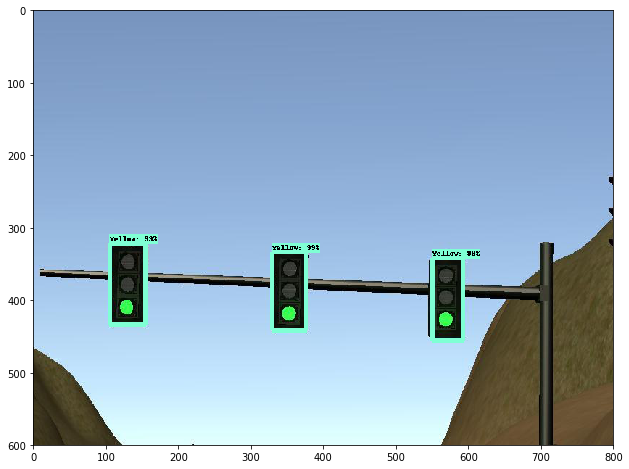

Yellow 0.999829
Distance (metres) 0.0
Time in milliseconds 359.67302322387695 

Yellow 0.999549
Distance (metres) 0.0
Time in milliseconds 359.67302322387695 

Yellow 0.998972
Distance (metres) 0.0
Time in milliseconds 359.67302322387695 



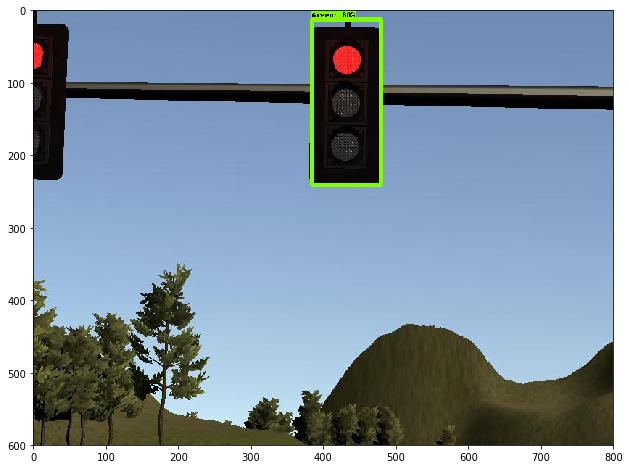

Green 0.801397
Distance (metres) 0.0
Time in milliseconds 22.205591201782227 



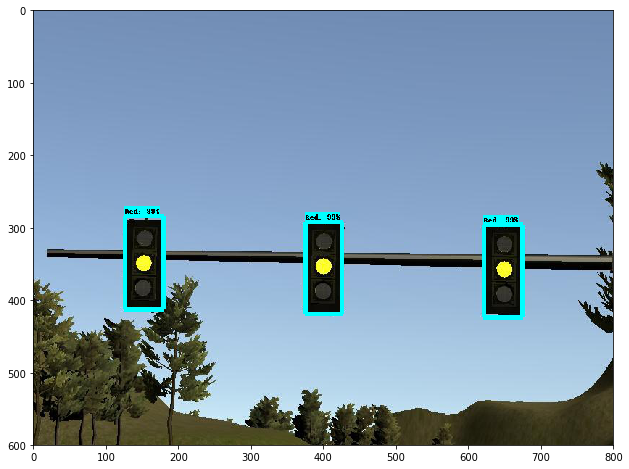

Red 0.999831
Distance (metres) 0.0
Time in milliseconds 21.848201751708984 

Red 0.999767
Distance (metres) 0.0
Time in milliseconds 21.848201751708984 

Red 0.998708
Distance (metres) 0.0
Time in milliseconds 21.848201751708984 



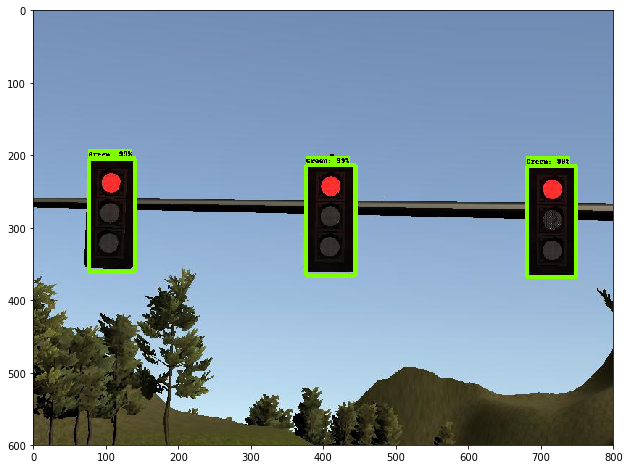

Green 0.998562
Distance (metres) 0.0
Time in milliseconds 22.220373153686523 

Green 0.996592
Distance (metres) 0.0
Time in milliseconds 22.220373153686523 

Green 0.993005
Distance (metres) 0.0
Time in milliseconds 22.220373153686523 



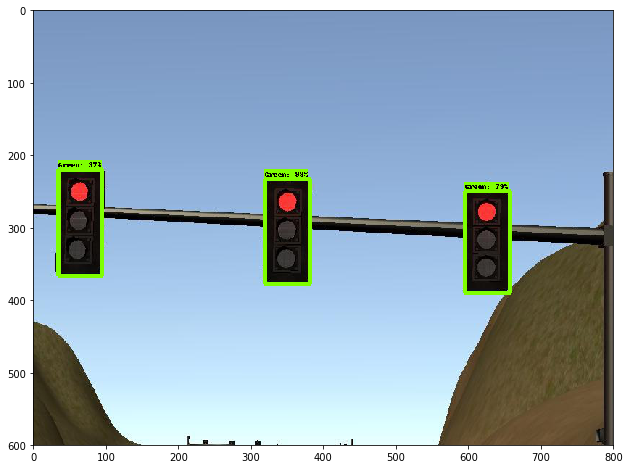

Green 0.995608
Distance (metres) 0.0
Time in milliseconds 22.20296859741211 

Green 0.971722
Distance (metres) 0.0
Time in milliseconds 22.20296859741211 

Green 0.790284
Distance (metres) 0.0
Time in milliseconds 22.20296859741211 



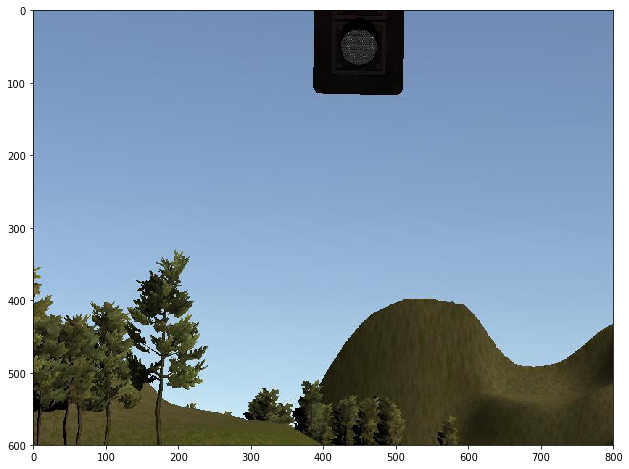

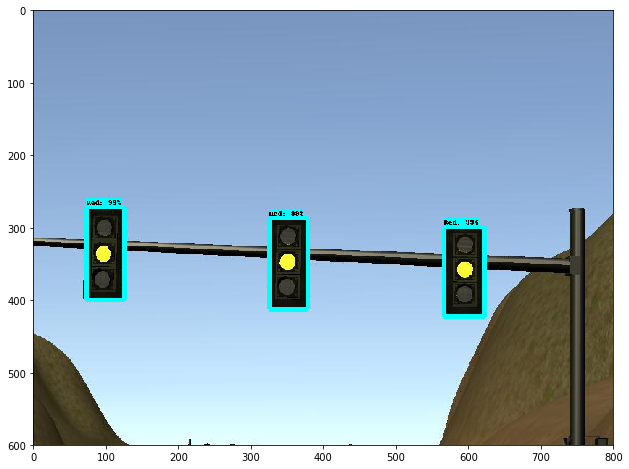

Red 0.999562
Distance (metres) 0.0
Time in milliseconds 22.559642791748047 

Red 0.997691
Distance (metres) 0.0
Time in milliseconds 22.559642791748047 

Red 0.995757
Distance (metres) 0.0
Time in milliseconds 22.559642791748047 



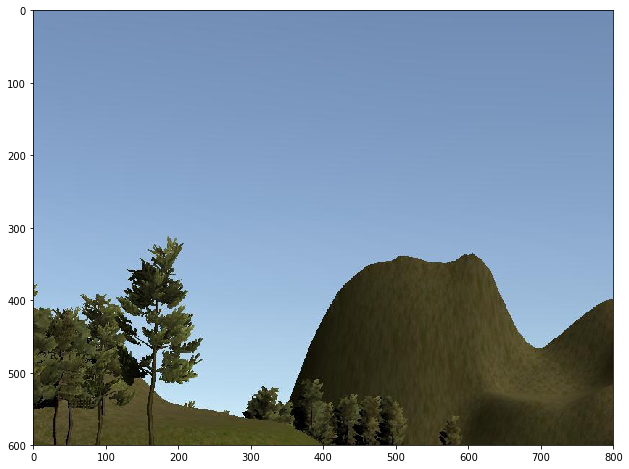

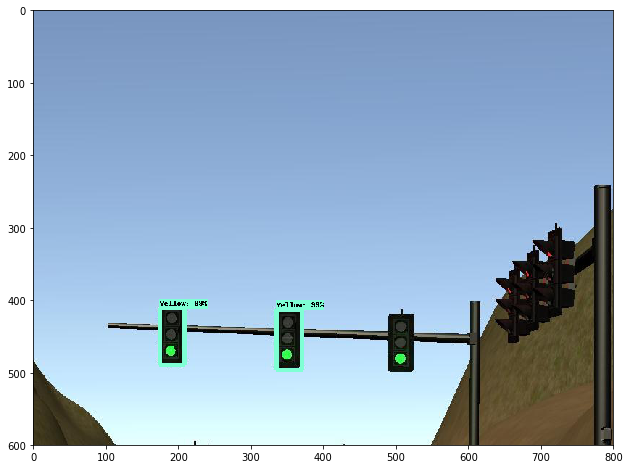

Yellow 0.999554
Distance (metres) 0.0
Time in milliseconds 22.535324096679688 

Yellow 0.996962
Distance (metres) 0.0
Time in milliseconds 22.535324096679688 



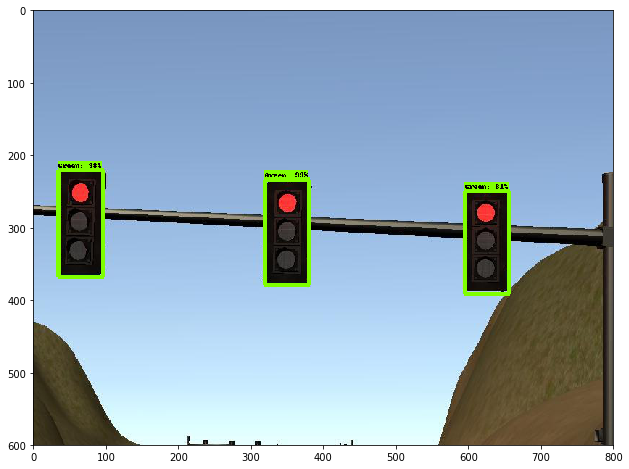

Green 0.997386
Distance (metres) 0.0
Time in milliseconds 22.4454402923584 

Green 0.987688
Distance (metres) 0.0
Time in milliseconds 22.4454402923584 

Green 0.818925
Distance (metres) 0.0
Time in milliseconds 22.4454402923584 



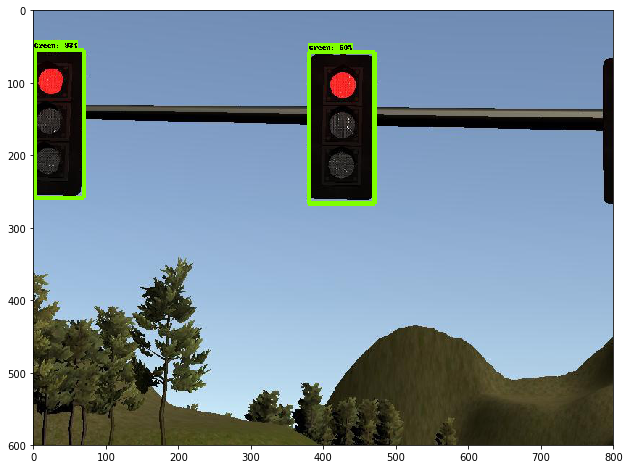

Green 0.930759
Distance (metres) 0.0
Time in milliseconds 22.011518478393555 

Green 0.600501
Distance (metres) 0.0
Time in milliseconds 22.011518478393555 



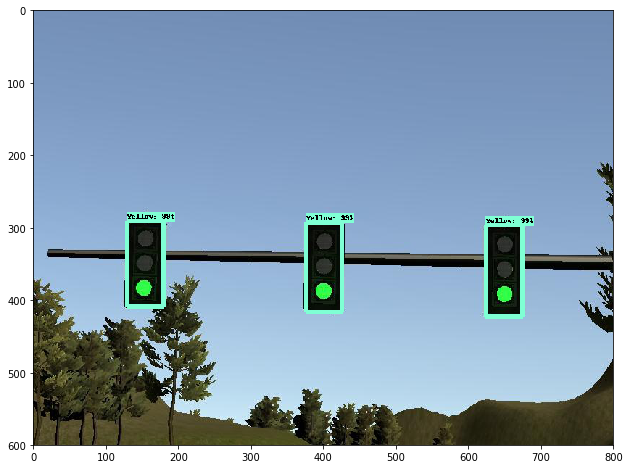

Yellow 0.999779
Distance (metres) 0.0
Time in milliseconds 22.501230239868164 

Yellow 0.999734
Distance (metres) 0.0
Time in milliseconds 22.501230239868164 

Yellow 0.999231
Distance (metres) 0.0
Time in milliseconds 22.501230239868164 



In [25]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})

            time1 = time.time()

            boxes = np.squeeze(boxes)
            scores = np.squeeze(scores)
            classes = np.squeeze(classes).astype(np.int32)
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np, boxes, classes, scores,
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            plt.show()

            min_score_thresh = .50
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:

                    class_name = category_index[classes[i]]['name']
                    print('{}'.format(class_name), scores[i])
                    
                    fx =  0.97428
                    fy =  1.73205
                    perceived_width_x = (boxes[i][3] - boxes[i][1]) * 800
                    perceived_width_y = (boxes[i][2] - boxes[i][0]) * 600

                    # ymin, xmin, ymax, xmax = box
                    # depth_prime = (width_real * focal) / perceived_width
                    perceived_depth_x = ((.1 * fx) / perceived_width_x)
                    perceived_depth_y = ((.3 * fy) / perceived_width_y )

                    estimated_distance = round((perceived_depth_x + perceived_depth_y) / 2)
                    print("Distance (metres)", estimated_distance)
                    print("Time in milliseconds", (time1 - time0) * 1000, "\n")